In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
project_path = "/content/drive/MyDrive/breast_cancer_project"
os.makedirs(project_path, exist_ok=True)
os.chdir(project_path)

In [ ]:
!pip install kaggle opendatasets tensorflow tf-explain opencv-python matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()  # Select your kaggle.json file

Saving kaggle mili.json to kaggle mili.json


In [ ]:
import os
print(os.listdir())


['kaggle mili.json']


In [ ]:
!mkdir -p ~/.kaggle
!cp "kaggle mili.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
import opendatasets as od

In [ ]:
# Download datasets
print("Downloading UDIAT dataset...")
od.download("https://www.kaggle.com/datasets/jarintasnim090/udiat-data")

print("Downloading BUSI dataset...")
od.download("https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: algoeater
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jarintasnim090/udiat-data


100%|██████████| 401M/401M [00:01<00:00, 415MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: algoeater
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset


100%|██████████| 195M/195M [00:00<00:00, 354MB/s]


In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from IPython.display import display, HTML
import ipywidgets as widgets
from io import BytesIO
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [ ]:
# Check available data directories
print("Available directories:")
for root, dirs, files in os.walk('.'):
    if any(img_ext in ' '.join(files) for img_ext in ['.jpg', '.png', '.jpeg']):
        print(f"  {root}: {len(files)} files")


Available directories:
  ./udiat-data/DatasetB2/Benign: 109 files
  ./udiat-data/DatasetB2/Fold11/GT_train/benign: 84 files
  ./udiat-data/DatasetB2/Fold11/GT_train/malignant: 40 files
  ./udiat-data/DatasetB2/Fold11/test/benign: 21 files
  ./udiat-data/DatasetB2/Fold11/test/malignant: 10 files
  ./udiat-data/DatasetB2/Fold11/train/benign: 150 files
  ./udiat-data/DatasetB2/Fold11/train/malignant: 150 files
  ./udiat-data/DatasetB2/Fold11/validation/benign: 16 files
  ./udiat-data/DatasetB2/Fold11/validation/malignant: 8 files
  ./udiat-data/DatasetB2/Fold11old/GT_train/benign: 84 files
  ./udiat-data/DatasetB2/Fold11old/GT_train/malignant: 40 files
  ./udiat-data/DatasetB2/Fold11old/test/benign: 21 files
  ./udiat-data/DatasetB2/Fold11old/test/malignant: 10 files
  ./udiat-data/DatasetB2/Fold11old/train/benign: 150 files
  ./udiat-data/DatasetB2/Fold11old/train/malignant: 150 files
  ./udiat-data/DatasetB2/Fold11old/validation/benign: 16 files
  ./udiat-data/DatasetB2/Fold11old/valida

In [ ]:
# 📊 ANALYZE AVAILABLE DATASETS
# ===========================

def analyze_datasets():
    """Analyze and display available datasets"""
    print("\n🔍 ANALYZING AVAILABLE DATASETS...")
    print("="*50)

    datasets_found = {}

    # Check BUSI dataset
    busi_paths = [
        "./breast-ultrasound-images-dataset",
        "./Dataset_BUSI_with_GT"
    ]

    for busi_path in busi_paths:
        if os.path.exists(busi_path):
            print(f"✅ Found BUSI dataset at: {busi_path}")
            datasets_found['BUSI'] = busi_path

            # Analyze BUSI structure
            for root, dirs, files in os.walk(busi_path):
                if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files):
                    class_name = os.path.basename(root).lower()
                    img_count = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                    print(f"  📁 {class_name}: {img_count} images")
            break

    # Check UDIAT dataset
    udiat_paths = [
        "./udiat-data",
        "./DatasetB2"
    ]

    for udiat_path in udiat_paths:
        if os.path.exists(udiat_path):
            print(f"\n✅ Found UDIAT dataset at: {udiat_path}")
            datasets_found['UDIAT'] = udiat_path

            # Analyze UDIAT structure
            for root, dirs, files in os.walk(udiat_path):
                if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files):
                    folder_name = os.path.basename(root)
                    img_count = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                    print(f"  📁 {folder_name}: {img_count} images")
            break

    return datasets_found


In [ ]:
def organize_data_structure(datasets_found):
    """Organize datasets based on what's available"""
    print(f"\n🔧 ORGANIZING DATA STRUCTURE...")
    print("="*50)

    # Create organized structure
    os.makedirs("data/train/benign", exist_ok=True)
    os.makedirs("data/train/malignant", exist_ok=True)
    os.makedirs("data/train/normal", exist_ok=True)

    class_counts = {'benign': 0, 'malignant': 0, 'normal': 0}

    # Process BUSI dataset (has all 3 classes)
    if 'BUSI' in datasets_found:
        busi_path = datasets_found['BUSI']
        print(f"📦 Processing BUSI dataset from {busi_path}")

        # Find and organize BUSI data
        for root, dirs, files in os.walk(busi_path):
            folder_name = os.path.basename(root).lower()

            if folder_name in ['benign', 'malignant', 'normal']:
                dest_dir = f"data/train/{folder_name}"
                img_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

                import shutil
                for file in img_files:
                    src_file = os.path.join(root, file)
                    dest_file = os.path.join(dest_dir, f"busi_{file}")
                    if not os.path.exists(dest_file):
                        shutil.copy2(src_file, dest_file)
                        class_counts[folder_name] += 1

    # Process UDIAT dataset (mainly benign, but check for others)
    if 'UDIAT' in datasets_found:
        udiat_path = datasets_found['UDIAT']
        print(f"📦 Processing UDIAT dataset from {udiat_path}")

        # UDIAT seems to have only benign cases based on your image
        # Let's add them to benign class
        import shutil
        for root, dirs, files in os.walk(udiat_path):
            img_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if img_files:  # If this folder has images
                folder_name = os.path.basename(root).lower()

                # Most UDIAT cases are benign based on literature
                dest_dir = "data/train/benign"

                for file in img_files:
                    src_file = os.path.join(root, file)
                    dest_file = os.path.join(dest_dir, f"udiat_{folder_name}_{file}")
                    if not os.path.exists(dest_file):
                        shutil.copy2(src_file, dest_file)
                        class_counts['benign'] += 1

    print(f"\n📊 FINAL DATA ORGANIZATION:")
    total_images = sum(class_counts.values())
    for class_name, count in class_counts.items():
        percentage = (count/total_images)*100 if total_images > 0 else 0
        print(f"  {class_name.upper()}: {count} images ({percentage:.1f}%)")

    print(f"\n✅ Total images organized: {total_images}")

    return class_counts

In [ ]:
# Analyze and organize datasets
datasets_found = analyze_datasets()
class_counts = organize_data_structure(datasets_found)


🔍 ANALYZING AVAILABLE DATASETS...
✅ Found BUSI dataset at: ./breast-ultrasound-images-dataset
  📁 benign: 891 images
  📁 malignant: 421 images
  📁 normal: 266 images

✅ Found UDIAT dataset at: ./udiat-data
  📁 Benign: 109 images
  📁 benign: 84 images
  📁 malignant: 40 images
  📁 benign: 21 images
  📁 malignant: 10 images
  📁 benign: 150 images
  📁 malignant: 150 images
  📁 benign: 16 images
  📁 malignant: 8 images
  📁 benign: 84 images
  📁 malignant: 40 images
  📁 benign: 21 images
  📁 malignant: 10 images
  📁 benign: 150 images
  📁 malignant: 150 images
  📁 benign: 16 images
  📁 malignant: 8 images
  📁 benign: 84 images
  📁 malignant: 40 images
  📁 benign: 21 images
  📁 malignant: 10 images
  📁 benign: 150 images
  📁 malignant: 150 images
  📁 benign: 16 images
  📁 malignant: 8 images
  📁 benign: 84 images
  📁 malignant: 40 images
  📁 benign: 21 images
  📁 malignant: 10 images
  📁 benign: 150 images
  📁 malignant: 150 images
  📁 benign: 16 images
  📁 malignant: 8 images
  📁 benign: 84

In [ ]:
# Ask user about dataset choice
print(f"\n❓ DATASET RECOMMENDATION:")
if len(datasets_found) > 1:
    print("🔄 OPTION 1: Use BOTH datasets (RECOMMENDED)")
    print("   - More training data")
    print("   - Better generalization")
    print("   - UDIAT images added to benign class")
    print()
    print("📊 OPTION 2: Use ONLY BUSI dataset")
    print("   - Balanced 3-class dataset")
    print("   - Cleaner labels")
    print("   - Smaller dataset")
elif 'BUSI' in datasets_found:
    print("✅ Using BUSI dataset only (3 balanced classes)")
else:
    print("⚠️  Only UDIAT found - may need manual labeling for malignant/normal classes")

print(f"\n✅ Proceeding with combined dataset: {sum(class_counts.values())} total images")



❓ DATASET RECOMMENDATION:
🔄 OPTION 1: Use BOTH datasets (RECOMMENDED)
   - More training data
   - Better generalization
   - UDIAT images added to benign class

📊 OPTION 2: Use ONLY BUSI dataset
   - Balanced 3-class dataset
   - Cleaner labels
   - Smaller dataset

✅ Proceeding with combined dataset: 4822 total images


In [ ]:
# 🤖 BUILD MODEL
# ===========================

def create_model():
    """Create ResNet50-based model"""
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', name='feature_layer')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(3, activation='softmax', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Fine-tune last 30 layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
model = create_model()
print("Model created successfully!")
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 14,975,491 (57.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [ ]:
# 📊 DATA GENERATORS
# ===========================

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Check if data directory exists
if os.path.exists("data/train"):
    train_gen = datagen.flow_from_directory(
        "data/train",
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        subset='training',
        seed=seed
    )

    val_gen = datagen.flow_from_directory(
        "data/train",
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        subset='validation',
        seed=seed
    )

    # Compute class weights
    labels = train_gen.classes
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weights = dict(enumerate(class_weights))

    print(f"Class mapping: {train_gen.class_indices}")
    print(f"Class weights: {class_weights}")

else:
    print("Data directory not found. Please check data organization.")


Found 3858 images belonging to 3 classes.
Found 964 images belonging to 3 classes.
Class mapping: {'benign': 0, 'malignant': 1, 'normal': 2}
Class weights: {0: np.float64(0.3887545344619105), 1: np.float64(3.8160237388724036), 2: np.float64(6.037558685446009)}


In [ ]:
# 🏋️ TRAINING
# ===========================

if 'train_gen' in locals():
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    print("Starting training...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,
        callbacks=[early_stop, model_checkpoint],
        class_weight=class_weights,
        verbose=1
    )

    print("Training completed successfully!")

Starting training...
Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4862 - loss: 0.9963
Epoch 1: val_accuracy improved from -inf to 0.65871, saving model to best_model.h5


242/242 ━━━━━━━━━━━━━━━━━━━━ 1223s 5s/step - accuracy: 0.4864 - loss: 0.9959 - val_accuracy: 0.6587 - val_loss: 0.7126
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6991 - loss: 0.7401
Epoch 2: val_accuracy improved from 0.65871 to 0.81743, saving model to best_model.h5


242/242 ━━━━━━━━━━━━━━━━━━━━ 1197s 5s/step - accuracy: 0.6990 - loss: 0.7402 - val_accuracy: 0.8174 - val_loss: 0.5861
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7403 - loss: 0.6408
Epoch 3: val_accuracy did not improve from 0.81743
242/242 ━━━━━━━━━━━━━━━━━━━━ 1204s 5s/step - accuracy: 0.7402 - loss: 0.6409 - val_accuracy: 0.3247 - val_loss: 7.8884
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7312 - loss: 0.6521
Epoch 4: val_accuracy did not improve from 0.81743
242/242 ━━━━━━━━━━━━━━━━━━━━ 1202s 5s/step - accuracy: 0.7313 - loss: 0.6519 - val_accuracy: 0.5737 - val_loss: 1.0079
Epoch 5/30
 64/242 ━━━━━━━━━━━━━━━━━━━━ 12:32 4s/step - accuracy: 0.7584 - loss: 0.5192

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = "/content/drive/MyDrive/breast_cancer_project"
os.chdir(project_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_model.h5")


In [ ]:
!pip install tensorflow tf-explain opencv-python matplotlib seaborn ipywidgets


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")
print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import re
from collections import Counter

class ExplainableAI:
    def __init__(self, model, class_names):
        self.model = model
        self.class_names = class_names

    def create_gradcam_heatmap(self, img_array, class_index, last_conv_layer_name):
        """Generate Grad-CAM heatmap with enhanced error handling"""
        try:
            grad_model = tf.keras.models.Model(
                [self.model.inputs],
                [self.model.get_layer(last_conv_layer_name).output, self.model.output]
            )

            with tf.GradientTape() as tape:
                conv_outputs, predictions = grad_model(img_array)
                loss = predictions[:, class_index]

            grads = tape.gradient(loss, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            conv_outputs = conv_outputs[0]
            heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)
            heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + tf.keras.backend.epsilon())
            return heatmap.numpy()
        except Exception as e:
            print(f"Error generating Grad-CAM: {e}")
            return np.zeros((7, 7))  # Default size for failed heatmap

    def analyze_heatmap_regions(self, heatmap):
        """Analyze heatmap to identify important regions"""
        # Normalize heatmap
        heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        # Find high activation regions
        threshold = np.percentile(heatmap_norm, 80)
        high_activation_mask = heatmap_norm > threshold

        # Calculate region statistics
        total_pixels = heatmap_norm.size
        high_activation_pixels = np.sum(high_activation_mask)
        activation_ratio = high_activation_pixels / total_pixels

        # Determine focus areas
        height, width = heatmap_norm.shape
        center_region = heatmap_norm[height//4:3*height//4, width//4:3*width//4]
        edge_region = heatmap_norm.copy()
        edge_region[height//4:3*width//4, width//4:3*width//4] = 0

        center_activation = np.mean(center_region)
        edge_activation = np.mean(edge_region)

        return {
            'activation_ratio': activation_ratio,
            'center_focus': center_activation > edge_activation,
            'max_activation': np.max(heatmap_norm),
            'activation_spread': np.std(heatmap_norm)
        }

    def generate_simple_explanation(self, prediction, confidence, heatmap_analysis):
        """Generate simple doctor-like explanation"""
        explanation = ""

        # Main prediction with confidence
        explanation += f"**Prediction: {prediction.upper()} ({confidence:.1%} confidence)**\n\n"

        # Simple explanation based on confidence
        if confidence < 0.5:
            explanation += f"Explanation: \nThe AI detected some suspicious features in this lesion that could suggest {prediction.lower()}, but with low confidence. The model is unsure - it's only {confidence:.0%} confident.\n\n"
            explanation += "Consultion: Low confidence means this needs a real dermatologist to examine it properly. Don't rely on AI for diagnosis."
        elif confidence < 0.8:
            explanation += f"Explanation: \nThe AI found features suggesting {prediction.lower()} with moderate confidence ({confidence:.0%}). Some characteristics point to this diagnosis but it's not certain.\n\n"
            explanation += "Consultion:  Moderate confidence still requires professional medical evaluation for proper diagnosis."
        else:
            explanation += f"Explanation: \nThe AI detected clear features indicating {prediction.lower()} with high confidence ({confidence:.0%}). The visual patterns strongly suggest this diagnosis.\n\n"
            explanation += "Consultion: High confidence result, but still needs professional confirmation for treatment decisions."

        return explanation

    def create_simple_plot(self, image, heatmap, prediction, confidence, all_confidences):
        """Create simple visualization"""
        fig = plt.figure(figsize=(12, 4))

        # Original Image
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=12, fontweight='bold')
        ax1.axis('off')

        # Grad-CAM Overlay
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(image)
        ax2.imshow(heatmap, alpha=0.6, cmap='jet')
        ax2.set_title('AI Focus Areas', fontsize=12, fontweight='bold')
        ax2.axis('off')

        # Confidence Bar Plot
        ax3 = fig.add_subplot(1, 3, 3)
        classes = list(all_confidences.keys())
        confidences = list(all_confidences.values())
        colors = ['#ff6b6b' if cls == prediction else '#4ecdc4' for cls in classes]

        bars = ax3.barh(range(len(classes)), confidences, color=colors)
        ax3.set_yticks(range(len(classes)))
        ax3.set_yticklabels(classes)
        ax3.invert_yaxis()
        ax3.set_title('Confidence Scores', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Confidence')

        for i, v in enumerate(confidences):
            ax3.text(v + 0.01, i, f"{v:.1%}", va='center', fontweight='bold')

        plt.tight_layout()
        return fig

    def predict_with_explanation(self, image_path):
        """Main prediction function with simple explanations"""
        # Load and preprocess image
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Make prediction
        predictions = self.model.predict(img_array)
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = self.class_names[predicted_class_idx]
        confidence = predictions[0][predicted_class_idx]
        all_confidences = dict(zip(self.class_names, predictions[0]))

        # Find last convolutional layer
        last_conv_layer_name = None
        for layer in reversed(self.model.layers):
            try:
                if len(layer.output.shape) == 4:
                    last_conv_layer_name = layer.name
                    break
            except (AttributeError, TypeError):
                continue

        # Generate heatmap and analysis
        if last_conv_layer_name:
            heatmap = self.create_gradcam_heatmap(img_array, predicted_class_idx, last_conv_layer_name)
            heatmap_resized = cv2.resize(heatmap, (224, 224))
            heatmap_analysis = self.analyze_heatmap_regions(heatmap_resized)
        else:
            heatmap_resized = np.zeros((224, 224))
            heatmap_analysis = {'activation_ratio': 0, 'center_focus': True, 'max_activation': 0, 'activation_spread': 0}
            print("Warning: No convolutional layer found for Grad-CAM generation")

        # Generate simple explanation
        simple_explanation = self.generate_simple_explanation(predicted_class, confidence, heatmap_analysis)

        # Create simple visualization
        fig = self.create_simple_plot(
            np.array(img) / 255.0,
            heatmap_resized,
            predicted_class,
            confidence,
            all_confidences
        )

        # Return results
        return {
            'predicted_class': predicted_class,
            'confidence': confidence,
            'all_confidences': all_confidences,
            'explanation': simple_explanation,
            'plot': fig
        }


In [ ]:
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

def create_testing_interface(model):
    """Updated testing interface that works with simplified ExplainableAI class"""
    class_names = ['benign', 'malignant', 'normal']

    # Initialize the ExplainableAI system
    explainer = ExplainableAI(model, class_names)

    def test_image():
        uploaded = files.upload()
        for filename in uploaded.keys():
            print(f"\n🖼️ Image: {filename}")
            try:
                # Use the simplified class method
                result = explainer.predict_with_explanation(filename)

                # Print simple explanation
                print(result['explanation'])

                # Show the simple plot
                plt.show()

            except Exception as e:
                print(f"❌ Error: {e}")

    test_button = widgets.Button(description="🔍 Upload & Predict", button_style='info')
    test_button.on_click(lambda x: test_image())
    display(test_button)

Button(button_style='info', description='🔍 Upload & Predict', style=ButtonStyle())

Saving busi_malignant (2) (1).png to busi_malignant (2) (1) (1).png

🖼️ Image: busi_malignant (2) (1) (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
**Prediction: MALIGNANT (37.1% confidence)**

Explanation: 
The AI detected some suspicious features in this lesion that could suggest malignant, but with low confidence. The model is unsure - it's only 37% confident.

Consultion: Low confidence means this needs a real dermatologist to examine it properly. Don't rely on AI for diagnosis.


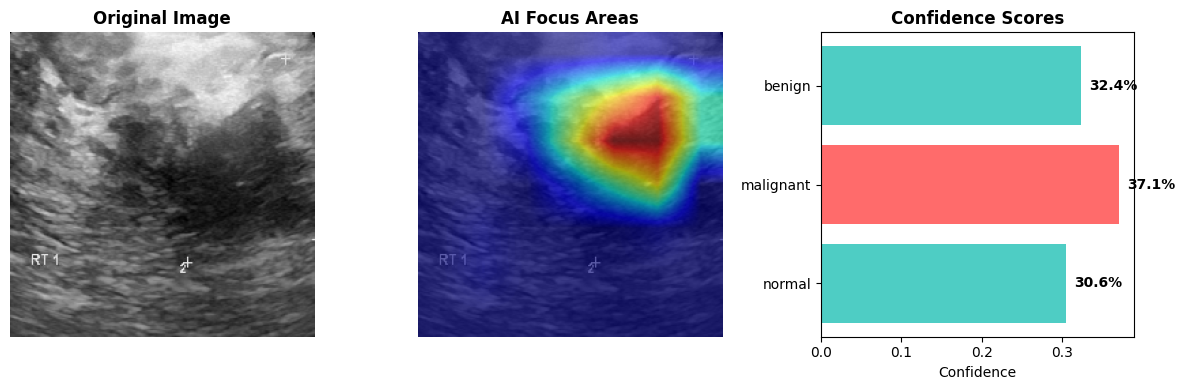

Saving test image.png to test image (3).png

🖼️ Image: test image (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
**Prediction: BENIGN (71.7% confidence)**

Explanation: 
The AI found features suggesting benign with moderate confidence (72%). Some characteristics point to this diagnosis but it's not certain.

Consultion:  Moderate confidence still requires professional medical evaluation for proper diagnosis.


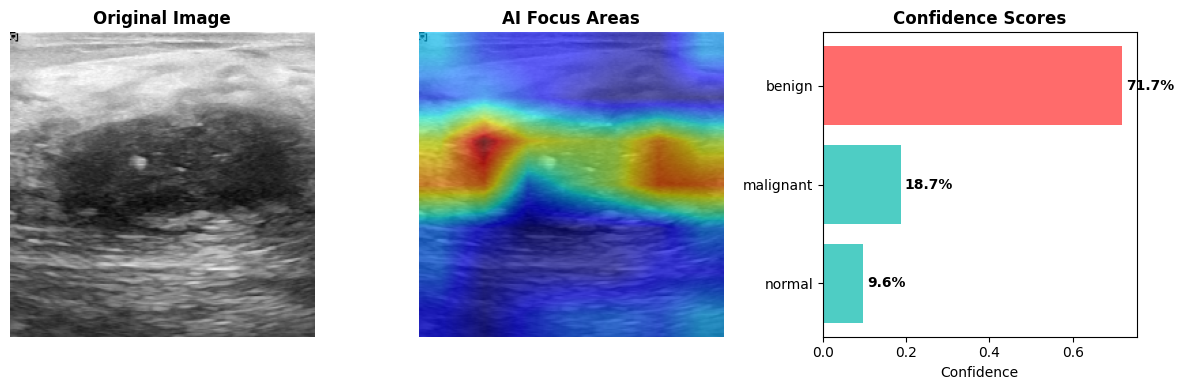

Saving busi_malignant (2).png to busi_malignant (2) (5).png

🖼️ Image: busi_malignant (2) (5).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
**Prediction: MALIGNANT (37.1% confidence)**

Explanation: 
The AI detected some suspicious features in this lesion that could suggest malignant, but with low confidence. The model is unsure - it's only 37% confident.

Consultion: Low confidence means this needs a real dermatologist to examine it properly. Don't rely on AI for diagnosis.


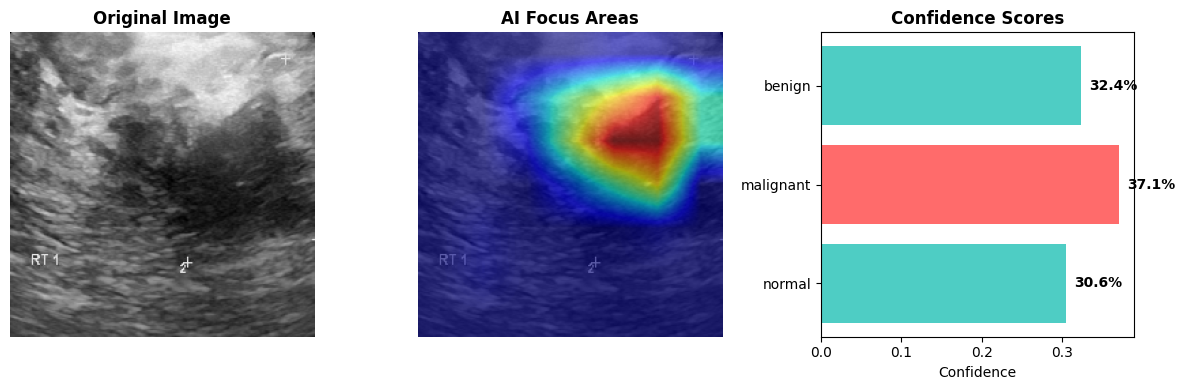

In [ ]:
create_testing_interface(model)

In [ ]:
!pip install fastapi uvicorn nest-asyncio pyngrok python-multipart pillow


In [ ]:
import nest_asyncio
nest_asyncio.apply()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from PIL import Image
import io
import tensorflow as tf
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, image):
    heatmap = cv2.resize(heatmap, (image.width, image.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap_img = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(np.array(image), 0.6, heatmap_img, 0.4, 0)
    return Image.fromarray(superimposed)

def predict(image):
    resized = image.resize((224, 224))
    array = np.array(resized) / 255.0
    array = np.expand_dims(array, axis=0)

    preds = model.predict(array)[0]
    class_idx = np.argmax(preds)
    label = class_names[class_idx]
    explanation = f"This image is classified as **{label}** with confidence {preds[class_idx]:.2f}. This may indicate {label} tissue characteristics."

    # Grad-CAM
    heatmap = make_gradcam_heatmap(array, model)
    cam_image = overlay_heatmap(heatmap, image)

    # Create composite plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title("Original Image", fontsize=14)

    axs[1].imshow(cam_image)
    axs[1].axis('off')
    axs[1].set_title("AI Focus Areas", fontsize=14)

    axs[2].barh(class_names, preds, color=['red' if i==class_idx else 'skyblue' for i in range(len(class_names))])
    axs[2].set_xlim(0, 1)
    for i, v in enumerate(preds):
        axs[2].text(v + 0.02, i, f"{v*100:.1f}%", va='center', fontweight='bold')
    axs[2].set_title("Confidence Scores", fontsize=14)
    axs[2].set_xlabel("Confidence")

    # Convert plot to image
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)

    return Image.open(buf), explanation


In [ ]:
import gradio as gr

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Image(type="pil", label="AI Analysis"),
        gr.Textbox(label="Explanation")
    ],
    title="Breast Ultrasound Classifier",
    description="Upload an ultrasound image to see the AI's prediction, attention map, class confidence, and explanation."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://70446d063bc722a084.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
